# Fitting a Line to Some Noisy Data
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 28)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (You are free to change them to whatever you want, but be aware that your plots may look different than others'.)

<ErrorbarContainer object of 3 artists>

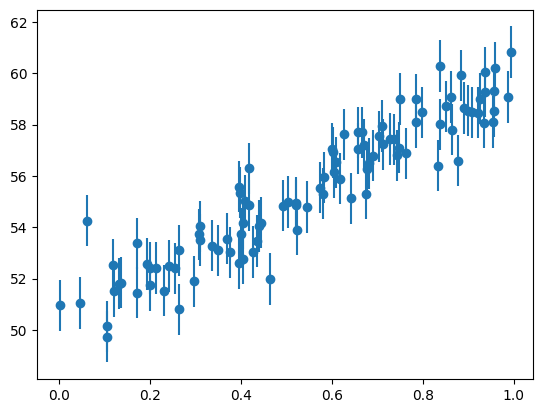

In [2]:
N = 100  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng()
x =  rng.random(size=N)
noise = rng.normal(loc=0.0, scale=1.0, size=N)
y =  ((m*x) +b ) + noise
dy =  np.full(N,sigma)# array of error bars for all the data (all `sigma`)

plt.errorbar(x,y,yerr=dy, fmt='o')


## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range.

**Bayes Theorem**

The posterior is proportional to the likelihood $\mathcal{L}$ times the prior on the parameters $\boldsymbol{\theta} = m, b$:

$$ p(\boldsymbol{\theta} | \mathrm{data}) \propto \mathcal{L}(\mathrm{data} | \boldsymbol{\theta}) \times p(\boldsymbol{\theta}) $$

**Likelihood**

Assuming Gaussian errors, the likelihood for each data point given the model with parameters $\theta$ will be:

$$ \mathcal{L}_i(y_i | \boldsymbol{\theta}, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left[-\frac{(y_i - y_\mathrm{model}(x_i, \boldsymbol{\theta}))^2}{2 \sigma_i^2}\right] $$

Or in log space:

$$ \ln \mathcal{L}_i(y_i | \boldsymbol{\theta}, x_i, \sigma_i) = -\frac{1}{2} \left( \ln{2\pi \sigma_i^2}  + \left[\frac{y_i - y_\mathrm{model}(x_i, \boldsymbol{\theta})}{\sigma_i}\right]^2 \right) $$

Assuming the data are independent, the likelihood for obtaining all of the data points is the product of the individual likelihoods:

$$ \mathcal{L}(\mathbf{y} | \boldsymbol{\theta}, \mathbf{x}, \boldsymbol{\sigma}) = \prod_i \mathcal{L}_i(y_i | \boldsymbol{\theta}, x_i, \sigma_i) $$

Or in log space you can sum the log likelihoods:

$$ \ln \mathcal{L} = \ln \left(\prod_i \mathcal{L}_i \right) = \sum_i \ln \mathcal{L}_i $$

**Prior**

The simplest prior is a uniform prior to restrict the parameters to some range, e.g.:

$$ m = \begin{cases}
1, & 0 < m < 100\\
0, & \mathrm{otherwise}
\end{cases}$$

In [3]:
lm_min = float(np.log(0))
lm_max = float(np.log(100))
lb_min = float(np.log(0))
lb_max = float(np.log(100))


m_min = 0
m_max = 100
b_min = 0
b_max = 100

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """
    m = np.log(theta[0])
    b = np.log(theta[1])

    if (lm_min < m < lm_max) and (lb_min < b < lb_max):
        return 1
    return 0


def log_likelihood(theta, x, y, dy):
    """complete"""
    #Setting variables to be used in function
    length = len(x)
    slope=theta[0]
    intercept=theta[1]
    L=0
    #Generating model data from input parameters
    noise = rng.normal(loc=0.0, scale=1.0, size=length)
    y_model = ((slope*x) +intercept ) + noise
    #calculating log likelyhood
    for i in range(length):
        L=L+ ( (np.log(np.pi *2*(dy[i]**2))) + (((y[i] - y_model[i])/ dy[i])**2))
    L= -0.5*L
    
        
        
    return L# complete



def log_posterior(theta, x, y, dy):
    lp = log_prior(theta)
    
    return lp + log_likelihood(theta, x, y, dy)

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_28368\682430671.py:1: RuntimeWarning: divide by zero encountered in log
  lm_min = float(np.log(0))
C:\Users\Ishaan\AppData\Local\Temp\ipykernel_28368\682430671.py:3: RuntimeWarning: divide by zero encountered in log
  lb_min = float(np.log(0))


## Evaluate it on a Grid
Now that you have defined `log_posterior`, produce a grid of $m$ and $b$ values, and evaluate the posterior at each point on the grid. Plot the results using `plt.contour` (contour plot) or `plt.contourf` (filled contour plot). Plot the input values of $m$ and $b$ as a point to see where they sit in the posterior space.

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_28368\682430671.py:26: RuntimeWarning: divide by zero encountered in log
  m = np.log(theta[0])
C:\Users\Ishaan\AppData\Local\Temp\ipykernel_28368\682430671.py:27: RuntimeWarning: divide by zero encountered in log
  b = np.log(theta[1])


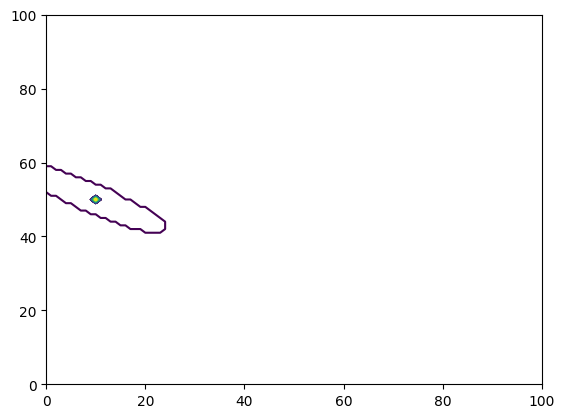

In [4]:
grid_spacing = 1.
m_range = np.arange(m_min, m_max + grid_spacing, grid_spacing)
b_range = np.arange(b_min, b_max + grid_spacing, grid_spacing)
posterior_grid=np.zeros((len(b_range), len(m_range)))
# complete
for i in range(len(b_range)):
    b_val = b_range[i]
    for j in range(len(m_range)):
        m_val = m_range[j]
        posterior_grid[i, j] = log_posterior([m_val, b_val], x, y, dy)



posterior_grid=np.exp(posterior_grid - np.max(posterior_grid)   )
plt.contour(m_range, b_range, posterior_grid, levels=300, cmap='viridis')


Find the parameters that maximize the posterior distribution. How close did we come to the parameters we used to generate the data?

In [5]:
best_val = -np.inf
i_max = j_max = 0

# Find the grid cell with the largest posterior
for i in range(len(m_range)):
    for j in range(len(b_range)):
        p = posterior_grid[j, i]
        if p > best_val:
            best_val = p
            i_max, j_max = i, j

# Convert indices back to parameters
m_infer = m_range[i_max]
b_infer = b_range[j_max]
print(f"m = {m_infer:.1f}, b = {b_infer:.1f}")

# Compute fractional errors
m_frac_err = (m_infer - m) / m
b_frac_err = (b_infer - b) / b
print(f"Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}")


m = 10.0, b = 50.0
Δm/m = 0.000, Δb/b = 0.000


### Marginalize Over Each Parameter
Since you have a grid of points, it is easy to integrate (sum) along the rows and columns of the grid. Use this method to find the marginalized posterior for each parameter and plot the results. How do the peaks of these distributions compare to our input parameters? (Hint: use the `axis` keyword in `np.sum`.) (Another hint: integrate the probability, not the log of the probability.)

**Marginalization**

If we just want to know the posterior for one parameter, we need to marginalize over all the possible values of the other parameter(s).

$$ p(\theta_1 | \mathrm{data}) = \int p(\theta_1, \theta_2 | \mathrm{data}) \, d\theta_2 $$

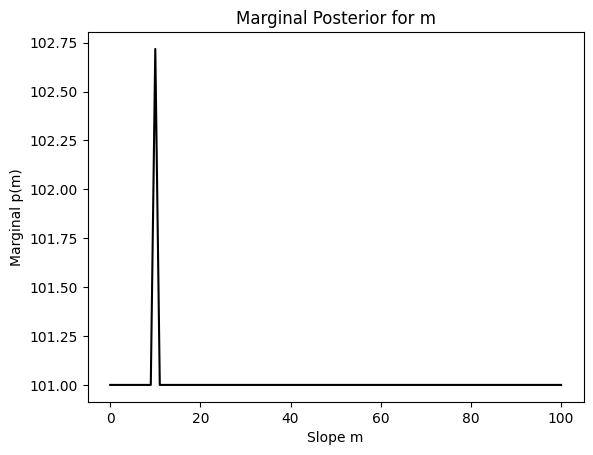

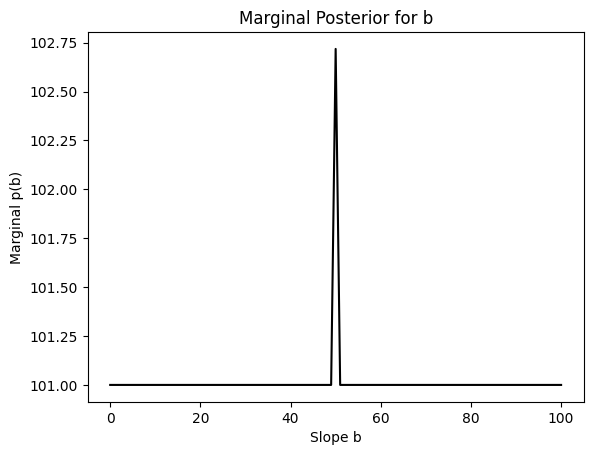

In [6]:
# 1. Convert log-posterior to relative posterior
P_grid = np.exp(posterior_grid )


posterior_m = P_grid.sum(axis=0) 

posterior_b = P_grid.sum(axis=1) 

plt.figure()
plt.xlabel('Slope m')
plt.ylabel('Marginal p(m)')
plt.title('Marginal Posterior for m')
plt.plot(m_range, posterior_m, '-k')



plt.figure()
plt.xlabel('Slope b')
plt.ylabel('Marginal p(b)')
plt.title('Marginal Posterior for b')
plt.plot(b_range, posterior_b, '-k')


## Evaluate it on a Random Sample (Monte Carlo)
Instead of evaluating the posterior at every point on the grid, it can be more efficient to evaluate it on a random sample of points within the parameter space. Generate some random points using the `np.random` module and evaluate the posterior at each one. Plot them and color code by the posterior. (Use the `c` parameter of `plt.scatter`). Plot the input values of $m$ and $b$ as a point to see where they sit in the posterior space. How does this plot compare to the plot in the previous section?

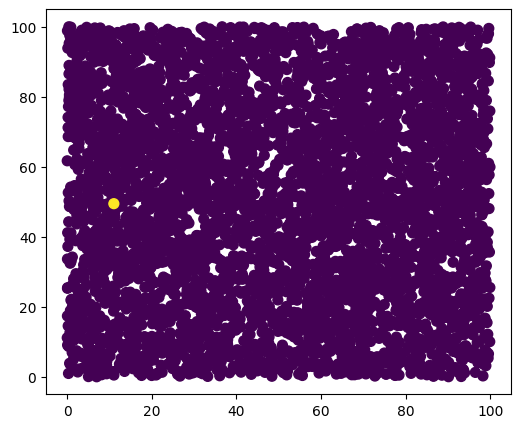

In [20]:
m_random = rng.uniform(m_min, m_max, size=5000)
b_random = rng.uniform(b_min, b_max, size=5000)

logP_random = np.empty(5000)
for i in range(5000):
    theta = [m_random[i], b_random[i]]
    logP_random[i] = log_posterior(theta, x, y, dy)

logP_shifted = logP_random - np.nanmax(logP_random)
posterior_random = np.exp(logP_shifted)

plt.figure(figsize=(6,5))
plt.scatter(m_random, b_random, c=posterior_random, alpha=1, s=50)


Its the exact same as before !

As before, find the parameters that maximize the posterior distribution. How close did we come to the parameters we used to generate the data?

In [22]:
best_val = -np.inf
i_max = j_max = 0

for i in range(len(m_range)):       
    for j in range(len(b_range)):   
        p = posterior_random[j, i]
        if p > best_val:
            best_val = p
            i_max, j_max = i, j
m_infer = m_range[i_max]
b_infer = b_range[j_max]
print(f'm = {m_infer:.1f}, b = {b_infer:.1f}')

# Fractional error of the inferred solution compared to the input 'true' parameters
m_frac_err = (m_infer - m) / m
b_frac_err = (b_infer - b) / b
print(f'Δm/m = {m_frac_err:.3f}, Δb/b = {b_frac_err:.3f}')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Note that it's complicated to calculate the marginalized posteriors using this method. You have to do some kind of binning or interpolation. Don't worry about that for now.

## Take-Away Message
Both methods work, but the point is it's wasteful (and impossible for higher dimensons or large $N$) to be sampling the posterior when the probability density is $e^{-100000}$. Later, we will see a much more efficient sampling method.

## Other Things to Try
- Redo the experiment but with a different prior. How much do your results change? Try plotting the priors on top of your marginalized posteriors.
- Redo the experiment but with a much larger scatter. How well do you do? Now do the priors affect your results?
- Add another parameter to your model: the intrinsic scatter. See if you can recover the value you used to generate the noisy data.